In [1]:
from __future__ import division

import glob
import os

import librosa
import medleydb as mdb

import numpy as np
import scipy

import matplotlib.pyplot as plt
import IPython.display

import seaborn as sns
%matplotlib inline


import jams
import itertools

from onsetGroundTruth import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Generate Data

In [2]:
def computeEnvelope(s):

    analytic_signal = scipy.signal.hilbert(s)
    amplitude_envelope = np.abs(analytic_signal)

    return amplitude_envelope

## Experiment on synthetic data 

In [3]:
def generateSine(f = 440, sr = 22050 , duration = 1):
    '''a function to generate a sine wav
    inpupt
    f: frequency in hz
    sr: sampling rate (samples/second)
    duration: in seconds
    '''
    
    samples = (np.sin(2*np.pi*np.arange(sr*duration)*f/sr))
    
    return samples

def generateInstrument(A, F, sr = 22050 , duration = 1):

    def instrument(f0,sr = 22050 , duration = 1):

        y = 0
        for f,a in zip(F,A):
            y = y + a*generateSine(f*f0,sr, duration) 
            
        return y
            
    return instrument

In [4]:
# make signal, mixes, and compute envelopes

A1 = np.array([1,0.2,0.2,0.1,0.1])
F1 = np.array([1,2,3,4,5])
inst1 = generateInstrument(A1,F1)

A2 = np.array([1,0.5, 0.25])
F2 = np.array([1,2,4])
inst2 = generateInstrument(A2,F2)

stem1 = inst1(440,duration=3)
stem2 = inst2(500,duration=3)

stem = np.array([stem1, stem2]).T

stem1_envelope = computeEnvelope(stem1)
stem2_envelope = computeEnvelope(stem2)

stem_envelope = np.array([stem1_envelope, stem2_envelope]).T


gain1 = np.abs(generateSine(f = 0.5,  duration = 3))
gain2 = np.abs(generateSine(f = 0.9,  duration = 3))

gain1[gain1<0.1] = 0
gain2[gain2<0.7] = 0

gain = np.array([gain1,gain2]).T

mix = (stem*gain).sum(1)

mix_envelope = computeEnvelope(mix)

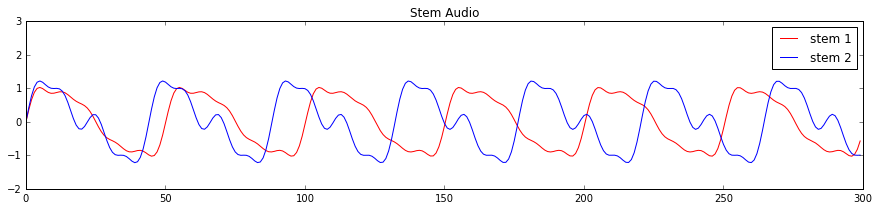

In [5]:
plt.figure(figsize=(15,3))

t = 300
pltEnvelope = False

# signal
plt.plot(stem1[:t], label = 'stem 1', c = 'r')
plt.plot(stem2[:t], label = 'stem 2', c = 'b')

#envelope
if pltEnvelope:
    plt.plot(stem1_envelope[:t],"--", label = 'stem 1 envelope', c = 'r')
    plt.plot(stem2_envelope[:t],"--", label = 'stem 2 envelope', c = 'b')

plt.legend(loc = 'best')
plt.ylim([-2,3])
plt.title('Stem Audio')

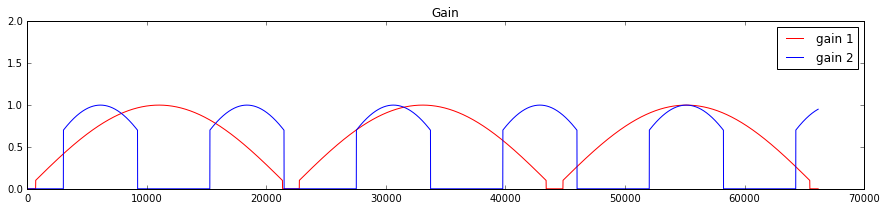

In [6]:
plt.figure(figsize=(15,3))

t_gain = 22050*5

plt.plot(gain1[:t_gain], label = 'gain 1', c = 'r')
plt.plot(gain2[:t_gain], label = 'gain 2', c = 'b')

plt.legend(loc = 'best')
plt.ylim([0,2])
plt.title('Gain')

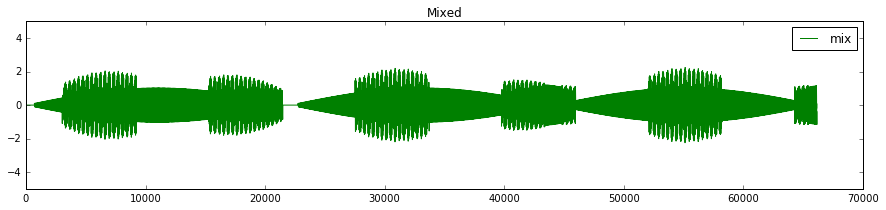

In [7]:
plt.figure(figsize=(15,3))

t = 22050*5

# signal
plt.plot(mix[:t], label = 'mix', c = 'g')
plt.legend(loc = 'best')
plt.ylim([-5,5])
plt.title('Mixed')

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


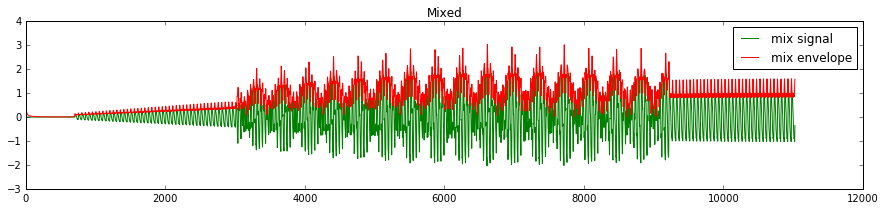

In [8]:
plt.figure(figsize=(15,3))

t = 22050*.5

# signal
plt.plot(mix[:t], label = 'mix signal', c = 'g')
plt.plot(mix_envelope[:t], label = 'mix envelope', c = 'r')
plt.legend(loc = 'best')
plt.title('Mixed')

onsetGroundTruth.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  stemTmp = stemsAudio[regStart:regEnd]
onsetGroundTruth.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mixTmp = mixAudio[regStart:regEnd]
onsetGroundTruth.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  gain[gainStart:gainEnd] = scipy.optimize.nnls(stemTmp,mixTmp)[0]


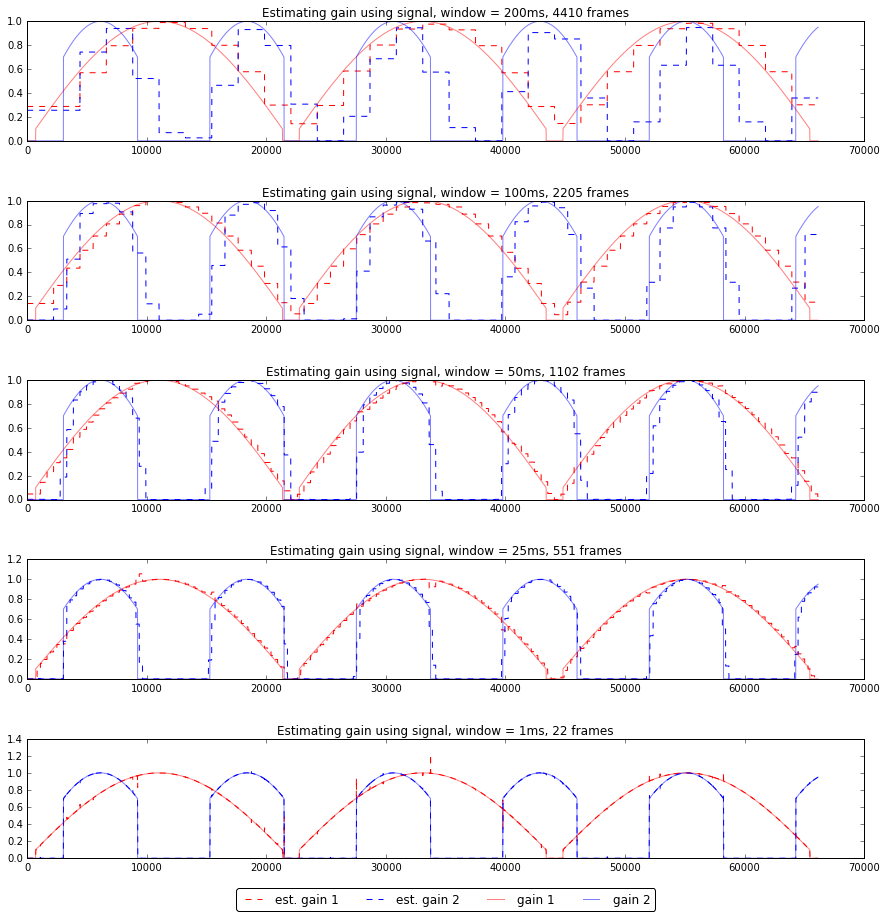

In [9]:
# estimation using signal
windowList = [200,100, 50, 25, 1]

f = plt.figure(figsize=(15,3*len(windowList)))

for i, window_ms in enumerate(windowList):
         
    window_frame = int(22050*(window_ms/1000))
        
    plt.subplot(len(windowList),1,i+1)
    
    estimatedGain_stem = estimateGain(mix, stem, window_frame, stride = None)
    
    plt.plot(estimatedGain_stem[:,0], "--", label = 'est. gain 1', c = 'r')
    plt.plot(estimatedGain_stem[:,1], "--", label = 'est. gain 2', c = 'b')
    
    plt.plot(gain[:,0], label = 'gain 1', c = 'r', alpha = 0.5)
    plt.plot(gain[:,1], label = 'gain 2', c = 'b', alpha = 0.5)
    
    plt.subplots_adjust(hspace = 0.5)
    
    titleStr = 'Estimating gain using signal, window = ' + str(window_ms) + 'ms, ' + str(window_frame) + ' frames'
    
    plt.title(titleStr)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=4)
   

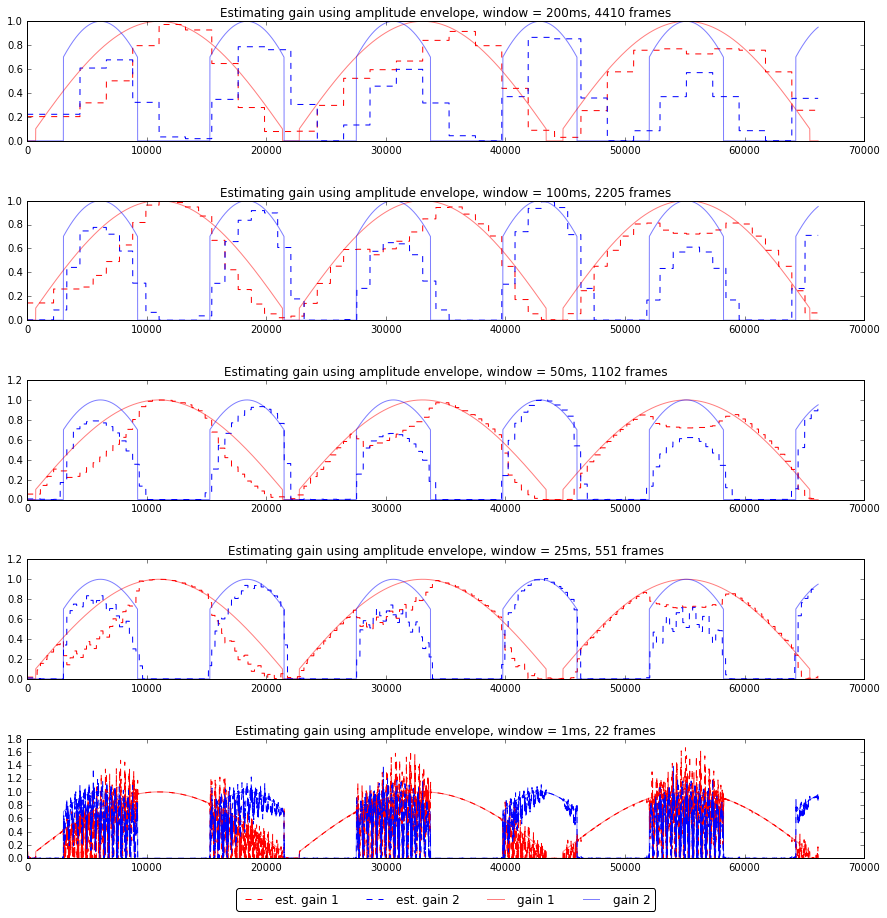

In [10]:
# estimation using envelope

windowList = [200,100, 50, 25, 1]

f = plt.figure(figsize=(15,3*len(windowList)))

for i, window_ms in enumerate(windowList):
         
    window_frame = int(22050*(window_ms/1000))
        
    plt.subplot(5,1,i+1)
    
    estimatedGain_envelope = estimateGain(mix_envelope, stem_envelope, window_frame, stride = None)
    
    plt.plot(estimatedGain_envelope[:,0], "--", label = 'est. gain 1', c = 'r')
    plt.plot(estimatedGain_envelope[:,1], "--", label = 'est. gain 2', c = 'b')
    
    plt.plot(gain[:,0], label = 'gain 1', c = 'r', alpha = 0.5)
    plt.plot(gain[:,1], label = 'gain 2', c = 'b', alpha = 0.5)
    
    plt.subplots_adjust(hspace = 0.5)
    
    titleStr = 'Estimating gain using amplitude envelope, window = ' + str(window_ms) + 'ms, ' + str(window_frame) + ' frames'
    
    plt.title(titleStr)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=4)
   

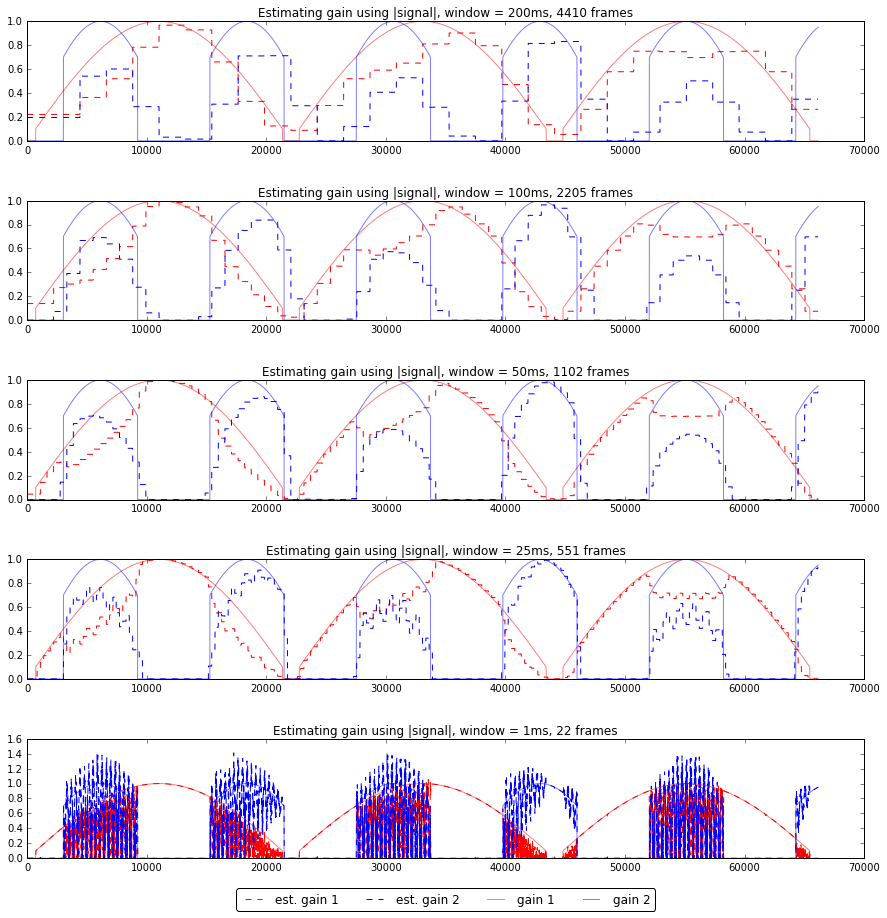

In [11]:
# estimation using absolute value of signal

windowList = [200,100, 50, 25, 1]

f = plt.figure(figsize=(15,3*len(windowList)))

for i, window_ms in enumerate(windowList):
         
    window_frame = int(22050*(window_ms/1000))
        
    plt.subplot(5,1,i+1)
    
    estimatedGain_stem = estimateGain(np.abs(mix), np.abs(stem), window_frame, stride = None)
    
    plt.plot(estimatedGain_stem[:,0], "--", label = 'est. gain 1', c = 'r')
    plt.plot(estimatedGain_stem[:,1], "--", label = 'est. gain 2', c = 'b')
    
    plt.plot(gain[:,0], label = 'gain 1', c = 'r', alpha = 0.5)
    plt.plot(gain[:,1], label = 'gain 2', c = 'b', alpha = 0.5)
    
    plt.subplots_adjust(hspace = 0.5)
    
    titleStr = 'Estimating gain using |signal|, window = ' + str(window_ms) + 'ms, ' + str(window_frame) + ' frames'
    
    plt.title(titleStr)
    
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=4)
   